# Group Equivariant Neural Networks

---

Based on the notebook from https://uvagedl.github.io/


In [ ]:
import numpy as np
import torch

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Groups


## $C4$

In [ ]:
class C4:

  @staticmethod
  def product(r: int, s: int) -> int:
    # Implements the *group law* of the group C_4.
    # The input `r` and `s` must be integers in {0, 1, 2, 3} and represent two elements of the group.
    # The method should return the integer representing the product of the two input elements.
    # You should also check that the inputs are valid.

    return (r + s) % 4

  @staticmethod
  def inverse(r: int) -> int:
    # Implements the *inverse* operation of the group C_4.
    # The input `r` must be an integer in {0, 1, 2, 3} and represents an element of the group.
    # The method should return the integer representing the inverse of input element.
    # You should also check that the input is valid.

    return (4 - r) % 4


In [ ]:
# Some test cases to check if your implementation is working
assert C4.product(1, 3) == 0
assert C4.product(0, 0) == 0
assert C4.product(2, 3) == 1
assert C4.inverse(0) == 0
assert C4.inverse(1) == 3

## $D_4$


In [ ]:
class D4:

  @staticmethod
  def product(a: tuple, b: tuple) -> tuple:
    # Implements the *group law* of the group D_4.
    # The input `a` and `b` must be tuples containing two integers, e.g. `a = (f, r)`.
    # The two integeres indicate whether the group element includes a reflection and the number of rotations.
    # The method should return the tuple representing the product of the two input elements.
    # You should also check that the inputs are valid.

    ### BEGIN SOLUTION
    f = (a[0] + b[0])%2
    if a[0] == 1 and b[0] == 0:
      return (f, C4.product(a[1], C4.inverse(b[1])))
    elif a[0] == 1:
      return (f, C4.product(C4.inverse(a[1]), b[1]))
    return (f, C4.product(a[1], b[1]))



    ### END SOLUTION

  @staticmethod
  def inverse(g: int) -> int:
    # Implements the *inverse* operation of the group D_4.
    # The input `g` must be a tuple containing two integers, e.g. `g = (f, r)`.
    # The two integeres indicate whether the group element includes a reflection and the number of rotations.
    # The method should return the tuple representing the inverse of the input element.
    # You should also check that the input is valid.

    ### BEGIN SOLUTION
    if g[0] == 0:
      return (g[0], C4.inverse(g[1]))
    return (1, g[1])

    ### END SOLUTION




In [ ]:
e = (0, 0) # the identity element
f = (1, 0) # the horizontal reflection
r = (0, 1) # the rotation by 90 degrees

# Let's verify that the implementation is consistent with the instructions given
assert D4.product(e, e) == e
assert D4.product(f, f) == e
assert D4.product(f, r) == D4.product(D4.inverse(r), f)

# Let's verify that the implementation satisfies the group axioms
a = (1, 2)
b = (0, 3)
c = (1, 1)
assert D4.product(a, e) == a
assert D4.product(e, a) == a
assert D4.product(b, D4.inverse(b)) == e
assert D4.product(D4.inverse(b), b) == e

assert D4.product(D4.product(a, b), c) == D4.product(a, D4.product(b, c))

## Group action


In [ ]:
def rotate(x: torch.Tensor, r: int) -> torch.Tensor:
  # Method which implements the action of the group element `g` indexed by `r` on the input image `x`.
  # The method returns the image `g.x`

  # note that we rotate the last 2 dimensions of the input, since we want to later use this method to rotate minibatches containing multiple images
  return x.rot90(r, dims=(-2, -1))


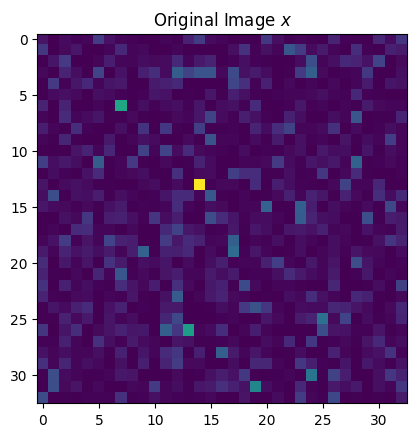

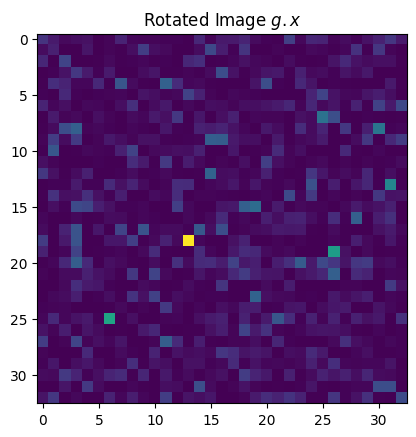

In [ ]:
x = torch.randn(1, 1, 33, 33)**2

r = 1
gx = rotate(x, r)

plt.imshow(x[0, 0].numpy())
plt.title('Original Image $x$')
plt.show()

plt.imshow(gx[0, 0].numpy())
plt.title('Rotated Image $g.x$')
plt.show()

# Equivariant Convolution Layers

### Group Action on the space of functions over $p4$


In [ ]:
def rotate_p4(y: torch.Tensor, r: int) -> torch.Tensor:
  # `y` is a function over p4, i.e. over the pixel positions and over the elements of the group C_4.
  # This method implements the action of a rotation `r` on `y`.
  # To be able to reuse this function later with a minibatch of inputs, assume that the last two dimensions (`dim=-2` and `dim=-1`) of `y` are the spatial dimensions
  # while `dim=-3` has size `4` and is the C_4 dimension.
  # All other dimensions are considered batch dimensions
  assert len(y.shape) >= 3
  assert y.shape[-3] == 4

  y = torch.roll(y, r, dims=-3)
  return torch.rot90(y, k=r, dims=[-2, -1])

  #y = torch.rot90(y, k=r, dims=[-2, -1])
  #return torch.roll(y, r, dims=-3)



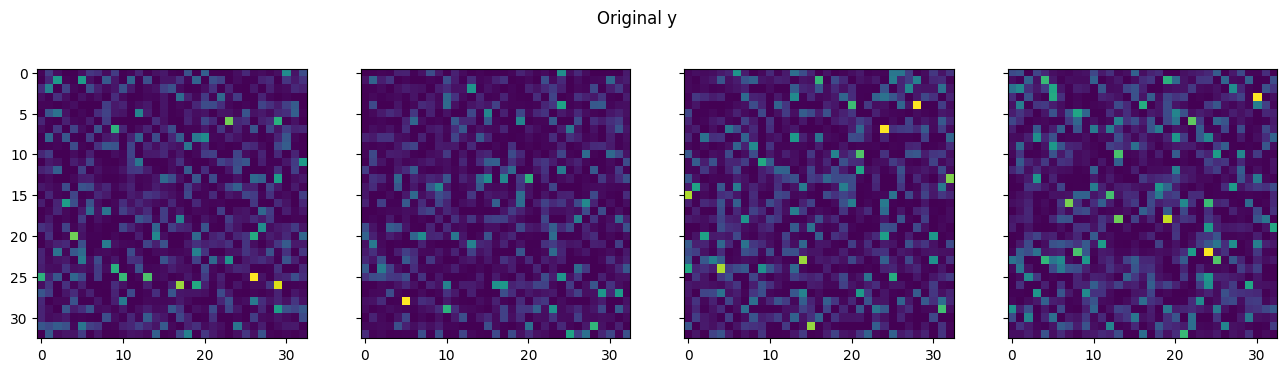

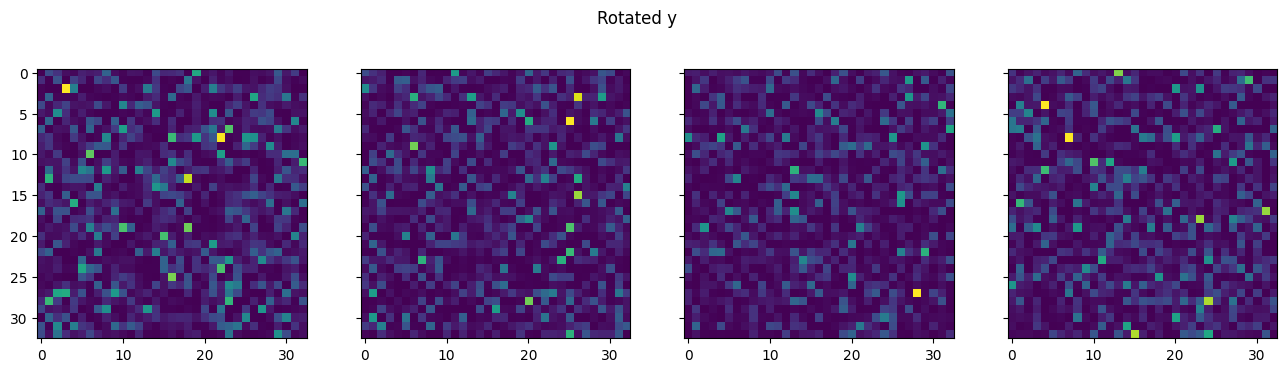

In [ ]:
# Let's test a rotation by r=1

y = torch.randn(1, 1, 4, 33, 33)**2


ry = rotate_p4(y, 1)

fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, squeeze=True, figsize=(16, 4))
for i in range(4):
  axes[i].imshow(y[0, 0, i].numpy())
fig.suptitle('Original y')
plt.show()

fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, squeeze=True, figsize=(16, 4))
for i in range(4):
  axes[i].imshow(ry[0, 0, i].numpy())
fig.suptitle('Rotated y')
plt.show()


# check that the images are actually rotated:
for _ in range(10):
  p = np.random.randint(0, 33, size=2)
  s = np.random.randint(0, 4)

  # compute r^-1 s
  _rs = C4.product(C4.inverse(1), s)

  # compute r^-1 p
  # note that the rotation is around the central pixel (16, 16)
  # A rotation by r^-1 = -90 degrees maps (X, Y) -> (Y, -X)
  center = np.array([16, 16])
  # center the point
  centered_p = p - center
  # rotate round the center
  rotated_p = np.array([centered_p[1], -centered_p[0]])
  # shift the point back
  _rp = rotated_p + center

  # Finally check that [r.y](p, s) = y(r^-1 p, r^-1 s)

  # However, in a machine, an image is stored with the coordinates (H-1-Y, X) rather than the usual (X, Y), where H is the height of the image;
  # we need to take this into account
  assert torch.isclose(
      ry[..., s, 32-p[1], p[0]],
      y[..., _rs, 32-_rp[1], _rp[0]],
      atol=1e-5, rtol=1e-5
    )




## Lifting Convolution

In [ ]:
class LiftingConv2d(torch.nn.Module):

  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, padding: int = 0, bias: bool = True):

    super(LiftingConv2d, self).__init__()

    self.kernel_size = kernel_size
    self.stride = 1
    self.dilation = 1
    self.padding = padding
    self.out_channels = out_channels
    self.in_channels = in_channels

    # In this block you need to create a tensor which stores the learnable filters
    # Recall that this layer should have `out_channels x in_channels` different learnable filters, each of shape `kernel_size x kernel_size`
    # During the forward pass, you will build the bigger filter of shape `out_channels x 4 x in_channels x kernel_size x kernel_size` by rotating 4 times
    # the learnable filters in `self.weight`

    # initialize the weights with some random values from a normal distribution with std = 1 / sqrt(out_channels * in_channels)

    self.weight = None
    self.weight = torch.nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size))
    torch.nn.init.normal_(self.weight, mean=0.0, std=1.0 / np.sqrt(out_channels * in_channels))


    # This time, you also need to build the bias
    # The bias is shared over the 4 rotations
    # In total, the bias has `out_channels` learnable parameters, one for each independent output
    # In the forward pass, you need to convert this bias into an "expanded" bias by repeating each entry `4` times

    self.bias = None
    if bias:
      self.bias = torch.nn.Parameter(torch.ones(out_channels)*0.01)

  def build_filter(self) ->torch.Tensor:
    # using the tensors of learnable parameters, build
    # - the `out_channels x 4 x in_channels x kernel_size x kernel_size` filter
    # - the `out_channels x 4` bias

    _filter = None
    _bias = None

    # Make sure that the filter and the bias tensors are on the same device of `self.weight` and `self.bias`

    # First build the filter
    # Recall that `_filter[:, i, :, :, :]` should contain the learnable filter rotated `i` times


    _filter = torch.stack([torch.rot90(self.weight, k=r, dims=[-2, -1]) for r in range(4)], dim=1)



    ### END SOLUTION

    # Now build the bias
    # Recall that `_bias[:, i]` should contain a copy of the learnable bias for each `i=0,1,2,3`

    if self.bias is not None:
      _bias = self.bias[:, None].expand(-1, 4)
    else:
      _bias = None

    return _filter, _bias

  def forward(self, x: torch.Tensor) -> torch.Tensor:

    _filter, _bias = self.build_filter()

    assert _bias.shape == (self.out_channels, 4)
    assert _filter.shape == (self.out_channels, 4, self.in_channels, self.kernel_size, self.kernel_size)

    # to be able to use torch.conv2d, we need to reshape the filter and bias to stack together all filters
    _filter = _filter.reshape(self.out_channels * 4, self.in_channels, self.kernel_size, self.kernel_size)
    _bias = _bias.reshape(self.out_channels * 4)

    out = torch.conv2d(x, _filter,
                       stride=self.stride,
                       padding=self.padding,
                       dilation=self.dilation,
                       bias=_bias)

    # `out` has now shape `batch_size x out_channels*4 x W x H`
    # we need to reshape it to `batch_size x out_channels x 4 x W x H` to have the shape we expect

    return out.view(-1, self.out_channels, 4, out.shape[-2], out.shape[-1])



In [ ]:
# Let's check if the layer is really equivariant

in_channels = 5
out_channels = 10
kernel_size = 3
batchsize = 6
S = 33

layer = LiftingConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size = kernel_size, padding=1, bias=True)
layer.eval()

x = torch.randn(batchsize, in_channels, S, S)
# the input image belongs to the space X, so we use the original action to rotate it
gx = rotate(x, 1)

# compute the output
psi_x = layer(x)
psi_gx = layer(gx)

# the output is a function in the space Y, so we need to use the new action to rotate it
g_psi_x = rotate_p4(psi_x, 1)

assert psi_x.shape == g_psi_x.shape
assert psi_x.shape == (batchsize, out_channels, 4, S, S)

# check the model is giving meaningful outputs
assert not torch.allclose(psi_x, torch.zeros_like(psi_x), atol=1e-4, rtol=1e-4)

# check equivariance
assert torch.allclose(psi_gx, g_psi_x, atol=1e-6, rtol=1e-6)

# check the model has the right number of parameters
assert layer.weight.numel() == in_channels * out_channels * kernel_size**2
assert layer.bias.numel() == out_channels

### Group-Convolution layer

In [ ]:
class GroupConv2d(torch.nn.Module):

  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, padding: int = 0, bias: bool = True):

    super(GroupConv2d, self).__init__()

    self.kernel_size = kernel_size
    self.stride = 1
    self.dilation = 1
    self.padding = padding
    self.out_channels = out_channels
    self.in_channels = in_channels

    # In this block you need to create a tensor which stores the learnable filters
    # Recall that this layer should have `out_channels x in_channels` different learnable filters, each of shape `4 x kernel_size x kernel_size`
    # During the forward pass, you will build the bigger filter of shape `out_channels x 4 x in_channels x 4 x kernel_size x kernel_size` by rotating 4 times
    # the learnable filters in `self.weight`

    # initialize the weights with some random values from a normal distribution with std = 1 / np.sqrt(out_channels * in_channels)

    self.weight = None

    ### BEGIN SOLUTION
    self.weight = torch.nn.Parameter(torch.Tensor(out_channels, in_channels, 4, kernel_size, kernel_size))
    torch.nn.init.normal_(self.weight, mean=0.0, std=1.0 / np.sqrt(out_channels * in_channels))


    ### END SOLUTION

    # The bias is shared over the 4 rotations
    # In total, the bias has `out_channels` learnable parameters, one for each independent output
    # In the forward pass, you need to convert this bias into an "expanded" bias by repeating each entry `4` times

    self.bias = None
    if bias:
      self.bias = torch.nn.Parameter(torch.ones(out_channels)*0.01)

  def build_filter(self) ->torch.Tensor:
    # using the tensors of learnable parameters, build
    # - the `out_channels x 4 x in_channels x 4 x kernel_size x kernel_size` filter
    # - the `out_channels x 4` bias

    _filter = None
    _bias = None

    # Make sure that the filter and the bias tensors are on the same device of `self.weight` and `self.bias`

    # First build the filter
    # Recall that `_filter[:, r, :, :, :, :]` should contain the learnable filter rotated `r` times
    # Also, recall that a rotation includes both a rotation of the pixels and a cyclic permutation of the 4 rotational input channels


    ### BEGIN SOLUTION

    _filter = torch.stack([rotate_p4(self.weight, r) for r in range(4)], dim=1)


    ### END SOLUTION

    # Now build the bias
    # Recall that `_bias[:, i]` should contain a copy of the learnable bias for each `i`

    if self.bias is not None:
      _bias = self.bias[:, None].expand(-1, 4)
    else:
      _bias = None

    return _filter, _bias

  def forward(self, x: torch.Tensor) -> torch.Tensor:

    _filter, _bias = self.build_filter()

    assert _bias.shape == (self.out_channels, 4)
    assert _filter.shape == (self.out_channels, 4, self.in_channels, 4, self.kernel_size, self.kernel_size)

    # to be able to use torch.conv2d, we need to reshape the filter and bias to stack together all filters
    _filter = _filter.reshape(self.out_channels * 4, self.in_channels * 4, self.kernel_size, self.kernel_size)
    _bias = _bias.reshape(self.out_channels * 4)

    # this time, also the input has shape `batch_size x in_channels x 4 x W x H`
    # so we need to reshape it to `batch_size x in_channels*4 x W x H` to be able to use torch.conv2d
    x = x.view(x.shape[0], self.in_channels*4, x.shape[-2], x.shape[-1])

    out = torch.conv2d(x, _filter,
                       stride=self.stride,
                       padding=self.padding,
                       dilation=self.dilation,
                       bias=_bias)

    # `out` has now shape `batch_size x out_channels*4 x W x H`
    # we need to reshape it to `batch_size x out_channels x 4 x W x H` to have the shape we expect

    return out.view(-1, self.out_channels, 4, out.shape[-2], out.shape[-1])



In [ ]:
# Let's check if the layer is really equivariant

in_channels = 5
out_channels = 10
kernel_size = 3
batchsize = 4
S = 33

layer = GroupConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size = kernel_size, padding=1, bias=True)
layer.eval()

x = torch.randn(batchsize, in_channels, 4, S, S)**2
# the input image belongs to the space Y, so this time we use the new action to rotate it
gx = rotate_p4(x, 1)

# compute the output
psi_x = layer(x)
psi_gx = layer(gx)

# the output is a function in the space Y, so we need to use the new action to rotate it
g_psi_x = rotate_p4(psi_x, 1)

assert psi_x.shape == g_psi_x.shape
assert psi_x.shape == (batchsize, out_channels, 4, S, S)

# check the model is giving meaningful outputs
assert not torch.allclose(psi_x, torch.zeros_like(psi_x), atol=1e-4, rtol=1e-4)

# check equivariance
assert torch.allclose(psi_gx, g_psi_x, atol=1e-5, rtol=1e-5)

# check the model has the right number of parameters
assert layer.weight.numel() == in_channels * out_channels * 4* kernel_size**2
assert layer.bias.numel() == out_channels

# $p4$-Equivariant Networks



In [ ]:
class C4CNN(torch.nn.Module):
  def __init__(self, n_classes=10):

    super(C4CNN, self).__init__()

    channels = [8, 16, 32, 64, 128]

    self.layers = torch.nn.Sequential(LiftingConv2d(1, channels[0], 3, 1),
                                      torch.nn.MaxPool3d((1, 3, 3), (1, 2, 2), (0, 1, 1)),
                                      torch.nn.ReLU(),
                                      GroupConv2d(channels[0], channels[1], 3, 1),
                                      torch.nn.MaxPool3d((1, 3, 3), (1, 2, 2), (0, 1, 1)),
                                      torch.nn.ReLU(),
                                      GroupConv2d(channels[1], channels[2], 3, 1),
                                      torch.nn.MaxPool3d((1, 3, 3), (1, 2, 2), (0, 1, 1)),
                                      torch.nn.ReLU(),
                                      GroupConv2d(channels[2], channels[3], 3, 1),
                                      torch.nn.MaxPool3d((1, 3, 3), (1, 2, 2), (0, 1, 1)),
                                      torch.nn.ReLU(),
                                      GroupConv2d(channels[3], channels[4], 3, 1),
                                      torch.nn.MaxPool3d((4, 3, 3), (1, 1, 1), (0, 0, 0)),
                                      torch.nn.ReLU())
    self.linear = torch.nn.Linear(128, 10)

  def forward(self, input: torch.Tensor):

    output = self.layers(input)
    return self.linear(output.reshape(input.shape[0], -1))


In [ ]:
# Let's try our model

net = C4CNN()

x = torch.randn(5, 1, 33, 33)

y = net(x)

assert y.shape == (5, 10)

# Let's check if the model is invariant!

gx = rotate(x, 1)

gy = net(gx)

assert torch.allclose(y, gy, atol=1e-5, rtol=1e-5)

## Data

In [ ]:
# download the dataset
!wget -nc http://www.iro.umontreal.ca/~lisa/icml2007data/mnist_rotation_new.zip
# uncompress the zip file
!unzip -n mnist_rotation_new.zip -d mnist_rotation_new

--2023-12-10 12:14:26--  http://www.iro.umontreal.ca/~lisa/icml2007data/mnist_rotation_new.zip
Resolving www.iro.umontreal.ca (www.iro.umontreal.ca)... 132.204.26.36
Connecting to www.iro.umontreal.ca (www.iro.umontreal.ca)|132.204.26.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58424278 (56M) [application/zip]
Saving to: ‘mnist_rotation_new.zip’

mnist_rotation_new. 100%[===================>]  55.72M  12.4MB/s    in 5.1s    

2023-12-10 12:14:32 (10.9 MB/s) - ‘mnist_rotation_new.zip’ saved [58424278/58424278]

Archive:  mnist_rotation_new.zip
  inflating: mnist_rotation_new/mnist_all_rotation_normalized_float_train_valid.amat  
  inflating: mnist_rotation_new/mnist_all_rotation_normalized_float_test.amat  


In [ ]:
!wget http://www-labs.iro.umontreal.ca/~lisa/icml2007data/mnist.zip
!unzip -n mnist.zip -d mnist

--2023-12-10 12:53:13--  http://www-labs.iro.umontreal.ca/~lisa/icml2007data/mnist.zip
Resolving www-labs.iro.umontreal.ca (www-labs.iro.umontreal.ca)... 132.204.26.154
Connecting to www-labs.iro.umontreal.ca (www-labs.iro.umontreal.ca)|132.204.26.154|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23653151 (23M) [application/zip]
Saving to: ‘mnist.zip’

mnist.zip           100%[===================>]  22.56M  5.00MB/s    in 7.2s    

2023-12-10 12:53:21 (3.14 MB/s) - ‘mnist.zip’ saved [23653151/23653151]

Archive:  mnist.zip
  inflating: mnist/mnist_train.amat  
  inflating: mnist/mnist_test.amat   


In [ ]:
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import tqdm

from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'


class MnistRotDataset(Dataset):

    def __init__(self, mode, transform=None):
        assert mode in ['train', 'test']

        if mode == "train":
            file = "mnist_rotation_new/mnist_all_rotation_normalized_float_train_valid.amat"
        else:
            file = "mnist_rotation_new/mnist_all_rotation_normalized_float_test.amat"

        self.transform = transform

        data = np.loadtxt(file, delimiter=' ')

        self.labels = data[:, -1].astype(np.int64)
        self.num_samples = len(self.labels)
        self.images = data[:, :-1].reshape(-1, 28, 28).astype(np.float32)

        # images in MNIST are only 28x28
        # we pad them to have shape 33 x 33
        self.images = np.pad(self.images, pad_width=((0,0), (2, 3), (2, 3)), mode='edge')

        assert self.images.shape == (self.labels.shape[0], 33, 33)

    def __getitem__(self, index):
        image, label = self.images[index], self.labels[index]
        image = Image.fromarray(image)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.labels)


train_set = MnistRotDataset('train', ToTensor())
test_set = MnistRotDataset('test', ToTensor())

def train_model(model: torch.nn.Module, train_set=train_set):

  train_loader = torch.utils.data.DataLoader(train_set, batch_size=64)
  loss_function = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)

  model.to(device)
  model.train()

  for epoch in tqdm.tqdm(range(30)):

    for i, (x, t) in enumerate(train_loader):

        optimizer.zero_grad()

        x = x.to(device)
        t = t.to(device)

        y = model(x)

        loss = loss_function(y, t)

        loss.backward()

        optimizer.step()

  return model


def test_model(model: torch.nn.Module, test_set=test_set):
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=64)
  total = 0
  correct = 0
  with torch.no_grad():
      model.eval()
      for i, (x, t) in tqdm.tqdm(enumerate(test_loader)):

          x = x.to(device)
          t = t.to(device)

          y = model(x)

          _, prediction = torch.max(y.data, 1)
          total += t.shape[0]
          correct += (prediction == t).sum().item()
  accuracy = correct/total*100.

  return accuracy

In [ ]:
class MnistDataset(Dataset):

    def __init__(self, mode, transform=None):
        assert mode in ['train', 'test']

        if mode == "train":
            file = "mnist/mnist_train.amat"
        else:
            file = "mnist/mnist_test.amat"

        self.transform = transform

        data = np.loadtxt(file)

        self.labels = data[:, -1].astype(np.int64)
        self.num_samples = len(self.labels)
        self.images = data[:, :-1].reshape(-1, 28, 28).astype(np.float32)

        # images in MNIST are only 28x28
        # we pad them to have shape 33 x 33
        self.images = np.pad(self.images, pad_width=((0,0), (2, 3), (2, 3)), mode='edge')

        assert self.images.shape == (self.labels.shape[0], 33, 33)

    def __getitem__(self, index):
        image, label = self.images[index], self.labels[index]
        image = Image.fromarray(image)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.labels)


In [ ]:
mnist_train_set = MnistDataset('train', ToTensor())
test_transforms = torchvision.transforms.Compose([torchvision.transforms.RandomRotation(180),
                                      torchvision.transforms.RandomHorizontalFlip(),
                                      ToTensor()])
mnist_transform_test = MnistDataset('test', transform=test_transforms)
mnist_test_set = MnistDataset('test', ToTensor())

In [ ]:
device

'cuda'

## Train and test

In [ ]:
model = C4CNN()

model = train_model(model)

acc = test_model(model)
print(f'Test Accuracy: {acc :.3f}')


100%|██████████| 30/30 [01:08<00:00,  2.27s/it]
782it [00:05, 143.36it/s]

Test Accuracy: 93.434


In [ ]:
model = C4CNN()

model = train_model(model)

acc = test_model(model)
print(f'Test Accuracy: {acc :.3f}')

100%|██████████| 30/30 [01:10<00:00,  2.36s/it]
782it [00:06, 121.11it/s]

Test Accuracy: 93.500


In [ ]:
# Let's check if the model is still invariant!

x = torch.randn(5, 1, 33, 33)

y = net(x)

gx = rotate(x, 1)

gy = net(gx)

assert torch.allclose(y, gy, atol=1e-5, rtol=1e-5)

### Batch Normalization

In [ ]:
class C4CNNWithBatchNorm(torch.nn.Module):
  def __init__(self, n_classes=10):

    super(C4CNNWithBatchNorm, self).__init__()

    channels = [8, 16, 32, 64, 128]

    self.layers = torch.nn.Sequential(LiftingConv2d(1, channels[0], 3, 1),
                                      torch.nn.BatchNorm3d(channels[0]),
                                      torch.nn.MaxPool3d((1, 3, 3), (1, 2, 2), (0, 1, 1)),
                                      torch.nn.ReLU(),
                                      GroupConv2d(channels[0], channels[1], 3, 1),
                                      torch.nn.BatchNorm3d(channels[1]),
                                      torch.nn.MaxPool3d((1, 3, 3), (1, 2, 2), (0, 1, 1)),
                                      torch.nn.ReLU(),
                                      GroupConv2d(channels[1], channels[2], 3, 1),
                                      torch.nn.BatchNorm3d(channels[2]),
                                      torch.nn.MaxPool3d((1, 3, 3), (1, 2, 2), (0, 1, 1)),
                                      torch.nn.ReLU(),
                                      GroupConv2d(channels[2], channels[3], 3, 1),
                                      torch.nn.BatchNorm3d(channels[3]),
                                      torch.nn.MaxPool3d((1, 3, 3), (1, 2, 2), (0, 1, 1)),
                                      torch.nn.ReLU(),
                                      GroupConv2d(channels[3], channels[4], 3, 1),
                                      torch.nn.BatchNorm3d(channels[4]))

    self.pool = torch.nn.MaxPool3d((4, 3, 3), (1, 1, 1), (0, 0, 0))
    self.act = torch.nn.ReLU()

    self.linear = torch.nn.Linear(128, 10)

  def forward(self, input: torch.Tensor):
    output = self.layers(input)
    output = self.act(self.pool(output))
    return self.linear(output.reshape(input.shape[0], -1))

  def before_pooling(self, input):
    with torch.no_grad():
      output = self.layers(input)
    return output

# Let's try our model

net = C4CNNWithBatchNorm()

x = torch.randn(5, 1, 33, 33)

y = net(x)

assert y.shape == (5, 10)

# Let's check if the model is invariant!

gx = rotate(x, 1)

gy = net(gx)

assert torch.allclose(y, gy, atol=1e-5, rtol=1e-5)

In [ ]:
model = C4CNNWithBatchNorm()
np.sum([p.numel() for p in model.parameters()])

393786

You can now train and test your model.
With the default parameters you should achieve an accuracy of roughly **95%**.

In [ ]:
model = C4CNNWithBatchNorm()

model = train_model(model)

acc = test_model(model)
print(f'Test Accuracy: {acc :.3f}')

100%|██████████| 30/30 [01:01<00:00,  2.06s/it]
782it [00:07, 109.93it/s]

Test Accuracy: 96.172


In [ ]:
model = C4CNNWithBatchNorm()

model = train_model(model, mnist_train_set)

acc = test_model(model, mnist_test_set)
print(f'Test Accuracy: {acc :.3f}')

100%|██████████| 30/30 [01:06<00:00,  2.22s/it]
782it [00:06, 122.99it/s]

Test Accuracy: 95.748


In [ ]:
acc = test_model(model, mnist_transform_test)
print(f'Test Accuracy: {acc :.3f}')

782it [00:18, 42.46it/s]

Test Accuracy: 62.956


In [ ]:
# Let's check if the model is still invariant!
x = torch.randn(5, 1, 33, 33)
y = net(x)
gx = rotate(x, 1)
gy = net(gx)
assert torch.allclose(y, gy, atol=1e-5, rtol=1e-5)


100%|██████████| 30/30 [01:11<00:00,  2.37s/it]
782it [00:05, 146.34it/s]

Test Accuracy: 95.888


### Without equivariance

In [ ]:
class CNNWithBatchNorm(torch.nn.Module):
  def __init__(self, n_classes=10):

    super(CNNWithBatchNorm, self).__init__()

    channels = [16, 32, 64, 128, 256]

    self.layers = torch.nn.Sequential(torch.nn.Conv2d(1, channels[0], 3, padding=1),
                                      torch.nn.BatchNorm2d(channels[0]),
                                      torch.nn.MaxPool2d((3, 3), (2, 2), (1, 1)),
                                      torch.nn.ReLU(),
                                      torch.nn.Conv2d(channels[0], channels[1], 3, padding=1),
                                      torch.nn.BatchNorm2d(channels[1]),
                                      torch.nn.MaxPool2d((3, 3), (2, 2), (1, 1)),
                                      torch.nn.ReLU(),
                                      torch.nn.Conv2d(channels[1], channels[2], 3, padding=1),
                                      torch.nn.BatchNorm2d(channels[2]),
                                      torch.nn.MaxPool2d((3, 3), (2, 2), (1, 1)),
                                      torch.nn.ReLU(),
                                      torch.nn.Conv2d(channels[2], channels[3], 3, padding=1),
                                      torch.nn.BatchNorm2d(channels[3]),
                                      torch.nn.MaxPool2d((3, 3), (2, 2), (1, 1)),
                                      torch.nn.ReLU(),
                                      torch.nn.Conv2d(channels[3], channels[4], 3, padding=1),
                                      torch.nn.BatchNorm2d(channels[4]),
                                      torch.nn.MaxPool2d((3, 3), (1, 1), (0, 0)),
                                      torch.nn.ReLU())
    self.linear = torch.nn.Linear(256, 10)

  def forward(self, input: torch.Tensor):
    output = self.layers(input)
    return self.linear(output.reshape(input.shape[0], -1))


# Let's try our model

net = CNNWithBatchNorm()

x = torch.randn(5, 1, 33, 33)

y = net(x)

assert y.shape == (5, 10)

# Let's check if the model is invariant!

gx = rotate(x, 1)

gy = net(gx)

assert torch.allclose(y, gy, atol=1e-5, rtol=1e-5)

AssertionError: ignored

In [ ]:
model = CNNWithBatchNorm()
print(np.sum([p.numel() for p in model.parameters()]))

395882


In [ ]:
model = train_model(model)

acc = test_model(model)
print(f'Test Accuracy: {acc :.3f}')


# Let's check if the model is still invariant!
x = torch.randn(5, 1, 33, 33)
y = net(x)
gx = rotate(x, 1)
gy = net(gx)
assert torch.allclose(y, gy, atol=1e-5, rtol=1e-5)

100%|██████████| 30/30 [00:43<00:00,  1.44s/it]
782it [00:04, 177.10it/s]

Test Accuracy: 92.428


AssertionError: ignored

In [ ]:
model = CNNWithBatchNorm()
model = train_model(model, mnist_train_set)

acc = test_model(model, mnist_test_set)
print(f'Test Accuracy: {acc :.3f}')

100%|██████████| 30/30 [00:57<00:00,  1.92s/it]
782it [00:04, 187.99it/s]

Test Accuracy: 98.200


In [ ]:
acc = test_model(model, mnist_transform_test)
print(f'Test Accuracy: {acc :.3f}')

782it [00:11, 71.00it/s]

Test Accuracy: 34.114


# $p4m$-Equivariant Networks


## Model

In [ ]:
class D4LiftingConv2d(torch.nn.Module):

  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, padding: int = 0, bias: bool = True):

    super(D4LiftingConv2d, self).__init__()

    self.kernel_size = kernel_size
    self.stride = 1
    self.dilation = 1
    self.padding = padding
    self.out_channels = out_channels
    self.in_channels = in_channels

    self.weight = None

    self.weight = torch.nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size))
    torch.nn.init.normal_(self.weight, mean=0.0, std=1.0 / np.sqrt(out_channels * in_channels))

    self.bias = None
    if bias:
      self.bias = torch.nn.Parameter(torch.ones(out_channels)*0.01)

  def build_filter(self) ->torch.Tensor:
    _filter = None
    _bias = None


    rotated_filters = [torch.rot90(self.weight, k=r, dims=[-2, -1]) for r in range(4)]
    rotated_flipped_filters = [torch.rot90(torch.flip(self.weight, dims=[-2]), k=r, dims=[-2, -1]) for r in range(4)]
    _filter = torch.stack(rotated_filters + rotated_flipped_filters, dim=1)


    if self.bias is not None:
      _bias = self.bias[:, None].expand(-1, 8)
    else:
      _bias = None

    return _filter, _bias

  def forward(self, x: torch.Tensor) -> torch.Tensor:

    _filter, _bias = self.build_filter()

    assert _bias.shape == (self.out_channels, 8)
    assert _filter.shape == (self.out_channels, 8, self.in_channels, self.kernel_size, self.kernel_size)

    _filter = _filter.reshape(self.out_channels * 8, self.in_channels, self.kernel_size, self.kernel_size)
    _bias = _bias.reshape(self.out_channels * 8)

    out = torch.conv2d(x, _filter,
                       stride=self.stride,
                       padding=self.padding,
                       dilation=self.dilation,
                       bias=_bias)

    return out.view(-1, self.out_channels, 8, out.shape[-2], out.shape[-1])



In [ ]:
def rotate_p4m(y: torch.Tensor, g: int) -> torch.Tensor:
  assert len(y.shape) >= 3
  assert y.shape[-3] == 8

  f = g // 4
  r = g % 4

  y_split = y.reshape(*y.shape[:-3], 2, 4, *y.shape[-2:])
  if f == 1:
    rolled_y = torch.flip(y_split, dims=[-4, -3, -2])
    y_split = torch.roll(rolled_y, 1, dims=-3)

  return rotate_p4(y_split, r).reshape(*y.shape)


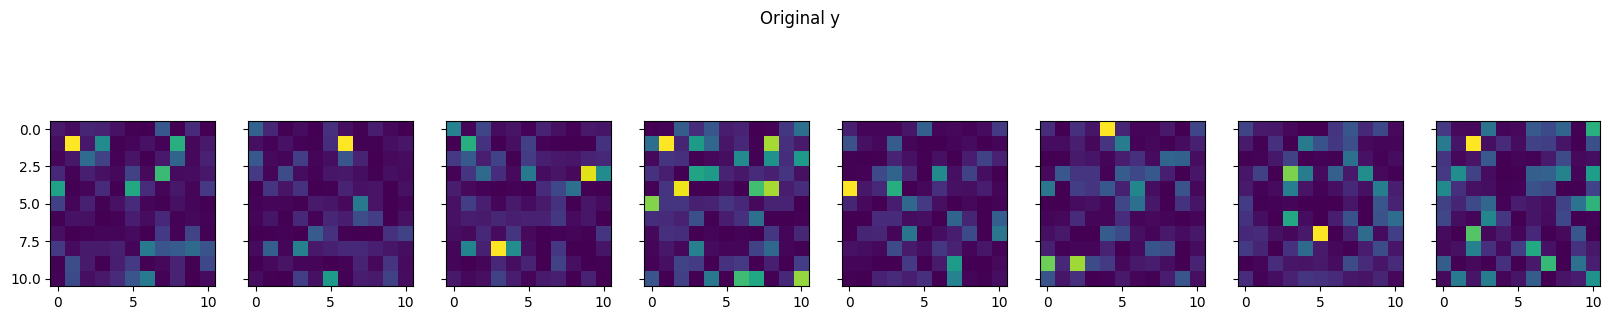

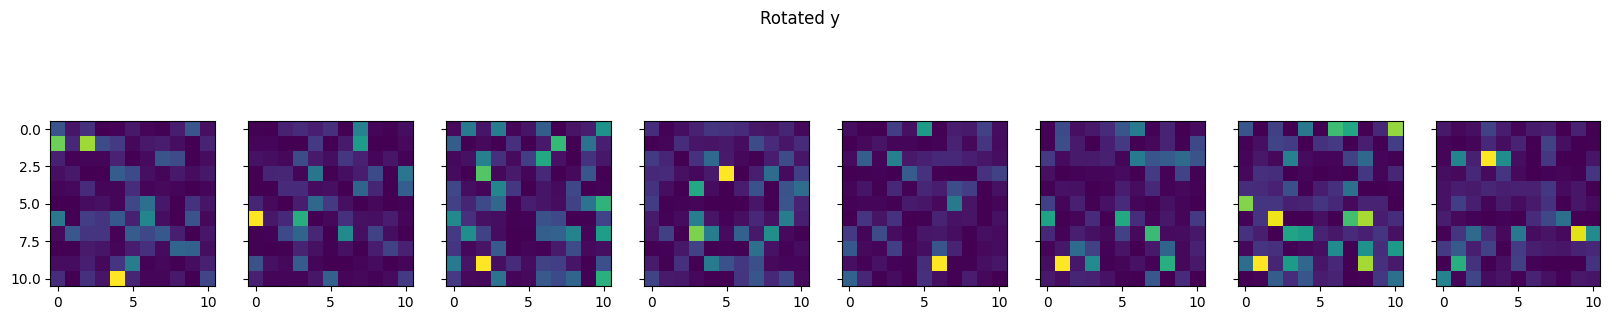

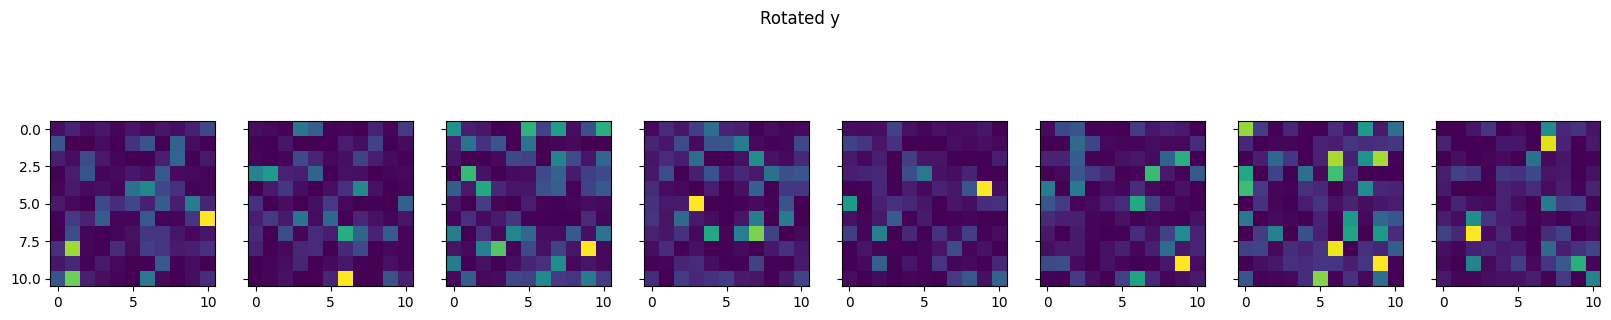

In [ ]:
# Let's test a rotation by r=1

y = torch.randn(1, 1, 8, 11, 11)**2
g = 5
ry = rotate_p4m(y, g)

R = 1
gy = rotate(y, R)
ry2 = rotate_p4m(gy, g)

fig, axes = plt.subplots(1, 8, sharex=True, sharey=True, squeeze=True, figsize=(20, 4))
for i in range(8):
  axes[i].imshow(y[0, 0, i].numpy())
fig.suptitle('Original y')
plt.show()

fig, axes = plt.subplots(1, 8, sharex=True, sharey=True, squeeze=True, figsize=(20, 4))
for i in range(8):
  axes[i].imshow(ry2[0, 0, i].numpy())
fig.suptitle('Rotated y')
plt.show()

fig, axes = plt.subplots(1, 8, sharex=True, sharey=True, squeeze=True, figsize=(20, 4))
for i in range(8):
  axes[i].imshow(ry[0, 0, i].numpy())
fig.suptitle('Rotated y')
plt.show()

In [ ]:
class D4GroupConv2d(torch.nn.Module):

  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, padding: int = 0, bias: bool = True):

    super(D4GroupConv2d, self).__init__()

    self.kernel_size = kernel_size
    self.stride = 1
    self.dilation = 1
    self.padding = padding
    self.out_channels = out_channels
    self.in_channels = in_channels

    self.weight = None

    self.weight = torch.nn.Parameter(torch.Tensor(out_channels, in_channels, 8, kernel_size, kernel_size))
    torch.nn.init.normal_(self.weight, mean=0.0, std=1.0 / np.sqrt(out_channels * in_channels))

    self.bias = None
    if bias:
      self.bias = torch.nn.Parameter(torch.ones(out_channels)*0.01)

  def build_filter(self) ->torch.Tensor:
    _filter = None
    _bias = None

    _filter = torch.stack([rotate_p4m(self.weight, r) for r in range(8)], dim=1)

    if self.bias is not None:
      _bias = self.bias[:, None].expand(-1, 8)
    else:
      _bias = None

    return _filter, _bias

  def forward(self, x: torch.Tensor) -> torch.Tensor:

    _filter, _bias = self.build_filter()

    assert _bias.shape == (self.out_channels, 8)
    assert _filter.shape == (self.out_channels, 8, self.in_channels, 8, self.kernel_size, self.kernel_size)

    _filter = _filter.reshape(self.out_channels * 8, self.in_channels * 8, self.kernel_size, self.kernel_size)
    _bias = _bias.reshape(self.out_channels * 8)

    x = x.view(x.shape[0], self.in_channels*8, x.shape[-2], x.shape[-1])

    out = torch.conv2d(x, _filter,
                       stride=self.stride,
                       padding=self.padding,
                       dilation=self.dilation,
                       bias=_bias)

    return out.view(-1, self.out_channels, 8, out.shape[-2], out.shape[-1])

In [ ]:
class D4CNNWithBatchNorm(torch.nn.Module):
  def __init__(self, n_classes=10):

    super(D4CNNWithBatchNorm, self).__init__()

    channels = [4, 16, 16, 64, 64]

    self.layers = torch.nn.Sequential(D4LiftingConv2d(1, channels[0], 3, 1),
                                      torch.nn.BatchNorm3d(channels[0]),
                                      torch.nn.MaxPool3d((1, 3, 3), (1, 2, 2), (0, 1, 1)),
                                      torch.nn.ReLU(),
                                      D4GroupConv2d(channels[0], channels[1], 3, 1),
                                      torch.nn.BatchNorm3d(channels[1]),
                                      torch.nn.MaxPool3d((1, 3, 3), (1, 2, 2), (0, 1, 1)),
                                      torch.nn.ReLU(),
                                      D4GroupConv2d(channels[1], channels[2], 3, 1),
                                      torch.nn.BatchNorm3d(channels[2]),
                                      torch.nn.MaxPool3d((1, 3, 3), (1, 2, 2), (0, 1, 1)),
                                      torch.nn.ReLU(),
                                      D4GroupConv2d(channels[2], channels[3], 3, 1),
                                      torch.nn.BatchNorm3d(channels[3]),
                                      torch.nn.MaxPool3d((1, 3, 3), (1, 2, 2), (0, 1, 1)),
                                      torch.nn.ReLU(),
                                      D4GroupConv2d(channels[3], channels[4], 3, 1),
                                      torch.nn.BatchNorm3d(channels[4]),
                                      torch.nn.MaxPool3d((8, 3, 3), (1, 1, 1), (0, 0, 0)),
                                      torch.nn.ReLU())
    self.linear = torch.nn.Linear(64, 10)

  def forward(self, input: torch.Tensor):

    output = self.layers(input)
    return self.linear(output.reshape(input.shape[0], -1))


## Train and test

In [ ]:
# Let's try our model

net = D4CNNWithBatchNorm()
print(np.sum([p.numel() for p in net.parameters()]))

x = torch.randn(5, 1, 33, 33)

y = net(x)

assert y.shape == (5, 10)

# Let's check if the model is invariant!

gx = rotate(x, 1)

gy = net(gx)

assert torch.allclose(y, gy, atol=1e-5, rtol=1e-5)

392858


In [ ]:
model = D4CNNWithBatchNorm()

model = train_model(model)

acc = test_model(model)
print(f'Test Accuracy: {acc :.3f}')


# Let's check if the model is still invariant!
x = torch.randn(5, 1, 33, 33)
y = net(x)
gx = rotate(x, 1)
gy = net(gx)
assert torch.allclose(y, gy, atol=1e-5, rtol=1e-5)

100%|██████████| 30/30 [01:25<00:00,  2.84s/it]
782it [00:07, 98.37it/s] 


Test Accuracy: 93.948


In [ ]:
x = torch.randn(5, 1, 33, 33)
y = net(x)
gx = torch.flip(x, dims=[-2])
gy = net(gx)
assert torch.allclose(y, gy, atol=1e-5, rtol=1e-5)

In [ ]:
model = D4CNNWithBatchNorm()

model = train_model(model, mnist_train_set)

acc = test_model(model, mnist_test_set)
print(f'Test Accuracy: {acc :.3f}')
acc = test_model(model, mnist_transform_test)
print(f'Test Accuracy: {acc :.3f}')

100%|██████████| 30/30 [01:28<00:00,  2.96s/it]
782it [00:11, 68.70it/s]


Test Accuracy: 94.206


782it [00:17, 44.24it/s]

Test Accuracy: 79.612


# $pn$-Equivariant Networks

## Model

In [ ]:
import torchvision

In [ ]:
def rot_n(image, k, n=4):
  angle = (360.0 / n) * k
  return torchvision.transforms.functional.rotate(image, angle)

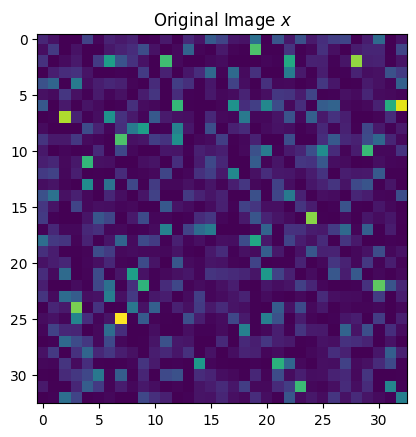

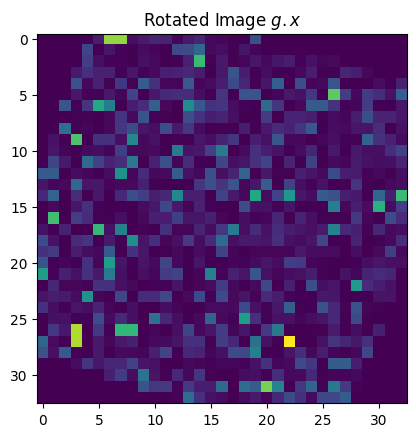

In [ ]:
x = torch.randn(1, 1, 33, 33)**2

r = 1
n = 5
gx = rot_n(x, r, n)

plt.imshow(x[0, 0].numpy())
plt.title('Original Image $x$')
plt.show()

plt.imshow(gx[0, 0].numpy())
plt.title('Rotated Image $g.x$')
plt.show()

In [ ]:
class PnLiftingConv2d(torch.nn.Module):
  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, padding: int = 0, bias: bool = True, n: int=4):

    super(PnLiftingConv2d, self).__init__()

    self.kernel_size = kernel_size
    self.stride = 1
    self.dilation = 1
    self.padding = padding
    self.out_channels = out_channels
    self.in_channels = in_channels
    self.n = n

    self.weight = None

    self.weight = torch.nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size))
    torch.nn.init.normal_(self.weight, mean=0.0, std=1.0 / np.sqrt(out_channels * in_channels))

    self.bias = None
    if bias:
      self.bias = torch.nn.Parameter(torch.ones(out_channels)*0.01)

  def build_filter(self) ->torch.Tensor:
    _filter = None
    _bias = None


    rotated_filters = [rot_n(self.weight, r, self.n) for r in range(self.n)]
    _filter = torch.stack(rotated_filters, dim=1)


    if self.bias is not None:
      _bias = self.bias[:, None].expand(-1, self.n)
    else:
      _bias = None

    return _filter, _bias

  def forward(self, x: torch.Tensor) -> torch.Tensor:

    _filter, _bias = self.build_filter()

    assert _bias.shape == (self.out_channels, self.n)
    assert _filter.shape == (self.out_channels, self.n, self.in_channels, self.kernel_size, self.kernel_size)

    _filter = _filter.reshape(self.out_channels * self.n, self.in_channels, self.kernel_size, self.kernel_size)
    _bias = _bias.reshape(self.out_channels * self.n)

    out = torch.conv2d(x, _filter,
                       stride=self.stride,
                       padding=self.padding,
                       dilation=self.dilation,
                       bias=_bias)

    return out.view(-1, self.out_channels, self.n, out.shape[-2], out.shape[-1])



In [ ]:
def rotate_pn(y: torch.Tensor, r: int, n: int=4) -> torch.Tensor:
  assert len(y.shape) >= 3
  assert y.shape[-3] == n

  y = torch.roll(y, r, dims=-3)
  if len(y.shape) == 4:
    return rot_n(y, r, n)
  if len(y.shape) == 5:
    return rot_n(y.reshape(y.shape[0]*y.shape[1], *y.shape[2:]), r, n).reshape(*y.shape)


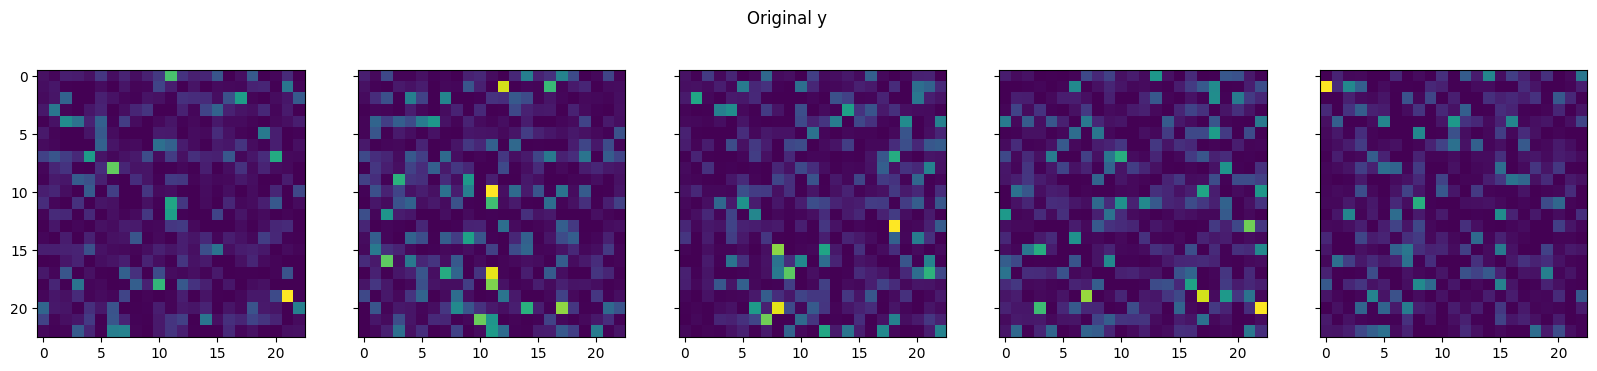

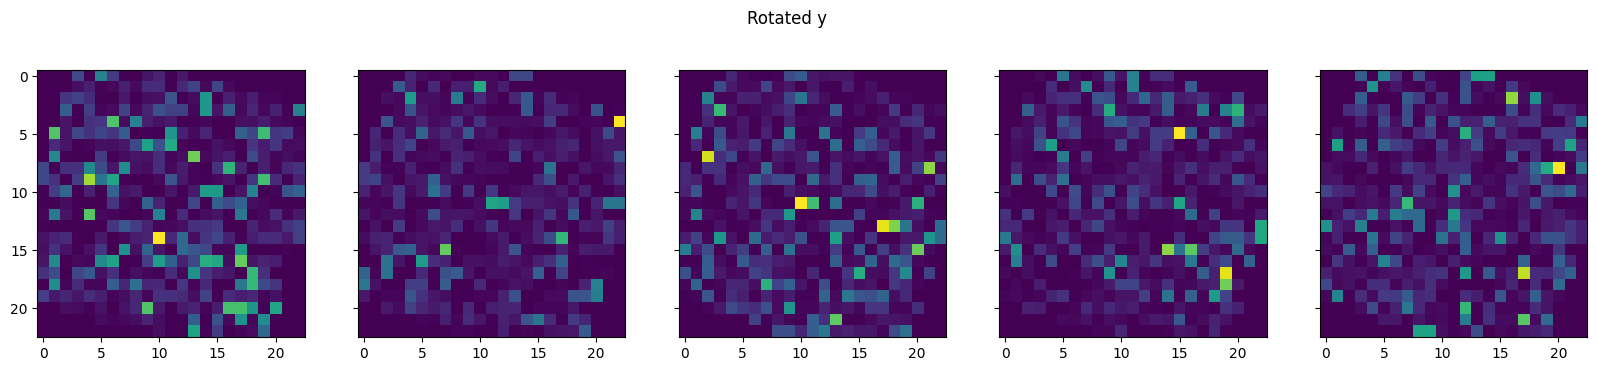

In [ ]:
# Let's test a rotation by r=1

n = 5
y = torch.randn(1, 1, n, 23, 23)**2
ry = rotate_pn(y, 1, n)

fig, axes = plt.subplots(1, n, sharex=True, sharey=True, squeeze=True, figsize=(20, 4))
for i in range(n):
  axes[i].imshow(y[0, 0, i].numpy())
fig.suptitle('Original y')
plt.show()

fig, axes = plt.subplots(1, n, sharex=True, sharey=True, squeeze=True, figsize=(20, 4))
for i in range(n):
  axes[i].imshow(ry[0, 0, i].numpy())
fig.suptitle('Rotated y')
plt.show()

In [ ]:
class PnGroupConv2d(torch.nn.Module):

  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, padding: int = 0, bias: bool = True, n: int=4):

    super(PnGroupConv2d, self).__init__()

    self.kernel_size = kernel_size
    self.stride = 1
    self.dilation = 1
    self.padding = padding
    self.out_channels = out_channels
    self.in_channels = in_channels
    self.n = n

    self.weight = None

    self.weight = torch.nn.Parameter(torch.Tensor(out_channels, in_channels, self.n, kernel_size, kernel_size))
    torch.nn.init.normal_(self.weight, mean=0.0, std=1.0 / np.sqrt(out_channels * in_channels))

    self.bias = None
    if bias:
      self.bias = torch.nn.Parameter(torch.ones(out_channels)*0.01)

  def build_filter(self) ->torch.Tensor:
    _filter = None
    _bias = None

    _filter = torch.stack([rotate_pn(self.weight, r, self.n) for r in range(self.n)], dim=1)

    if self.bias is not None:
      _bias = self.bias[:, None].expand(-1, self.n)
    else:
      _bias = None

    return _filter, _bias

  def forward(self, x: torch.Tensor) -> torch.Tensor:

    _filter, _bias = self.build_filter()

    assert _bias.shape == (self.out_channels, self.n)
    assert _filter.shape == (self.out_channels, self.n, self.in_channels, self.n, self.kernel_size, self.kernel_size)

    _filter = _filter.reshape(self.out_channels * self.n, self.in_channels * self.n, self.kernel_size, self.kernel_size)
    _bias = _bias.reshape(self.out_channels * self.n)

    x = x.view(x.shape[0], self.in_channels*self.n, x.shape[-2], x.shape[-1])

    out = torch.conv2d(x, _filter,
                       stride=self.stride,
                       padding=self.padding,
                       dilation=self.dilation,
                       bias=_bias)

    return out.view(-1, self.out_channels, self.n, out.shape[-2], out.shape[-1])

In [ ]:
class PnCNNWithBatchNorm(torch.nn.Module):
  def __init__(self, n=4, n_classes=10, channels=None):

    super(PnCNNWithBatchNorm, self).__init__()

    if channels is None:
      channels = [8, 16, 32, 64, 64]

    self.layers = torch.nn.Sequential(PnLiftingConv2d(1, channels[0], 3, 1, n=n),
                                      torch.nn.BatchNorm3d(channels[0]),
                                      torch.nn.MaxPool3d((1, 3, 3), (1, 2, 2), (0, 1, 1)),
                                      torch.nn.ReLU(),
                                      PnGroupConv2d(channels[0], channels[1], 3, 1, n=n),
                                      torch.nn.BatchNorm3d(channels[1]),
                                      torch.nn.MaxPool3d((1, 3, 3), (1, 2, 2), (0, 1, 1)),
                                      torch.nn.ReLU(),
                                      PnGroupConv2d(channels[1], channels[2], 3, 1, n=n),
                                      torch.nn.BatchNorm3d(channels[2]),
                                      torch.nn.MaxPool3d((1, 3, 3), (1, 2, 2), (0, 1, 1)),
                                      torch.nn.ReLU(),
                                      PnGroupConv2d(channels[2], channels[3], 3, 1, n=n),
                                      torch.nn.BatchNorm3d(channels[3]),
                                      torch.nn.MaxPool3d((1, 3, 3), (1, 2, 2), (0, 1, 1)),
                                      torch.nn.ReLU(),
                                      PnGroupConv2d(channels[3], channels[4], 3, 1, n=n),
                                      torch.nn.BatchNorm3d(channels[4]),
                                      torch.nn.MaxPool3d((n, 3, 3), (1, 1, 1), (0, 0, 0)),
                                      torch.nn.ReLU())
    self.linear = torch.nn.Linear(channels[-1], 10)

  def forward(self, input: torch.Tensor):
    input = self.layers(input)
    return self.linear(input.reshape(input.shape[0], -1))


## Train and test

In [ ]:
# Let's try our model

net = PnCNNWithBatchNorm(n=6, channels=[8, 16, 32, 64, 72])
print(np.sum([p.numel() for p in net.parameters()]))

x = torch.randn(5, 1, 33, 33)

y = net(x)

assert y.shape == (5, 10)

395362


In [ ]:
model = PnCNNWithBatchNorm(n=6, channels=[8, 16, 32, 64, 72])

model = train_model(model)

acc = test_model(model)
print(f'Test Accuracy: {acc :.3f}')

100%|██████████| 30/30 [02:33<00:00,  5.13s/it]
782it [00:16, 47.34it/s]

Test Accuracy: 94.824


In [ ]:
model = PnCNNWithBatchNorm(n=5, channels=[8, 16, 32, 64, 94])
print(np.sum([p.numel() for p in model.parameters()]))

393344


In [ ]:
model = train_model(model)

acc = test_model(model)
print(f'Test Accuracy: {acc :.3f}')

100%|██████████| 30/30 [02:10<00:00,  4.37s/it]
782it [00:17, 44.63it/s]

Test Accuracy: 94.528


In [ ]:
model = PnCNNWithBatchNorm(n=7, channels=[8, 16, 16, 64, 75])
print(np.sum([p.numel() for p in model.parameters()]))

392473


In [ ]:
model = train_model(model)

acc = test_model(model)
print(f'Test Accuracy: {acc :.3f}')

100%|██████████| 30/30 [02:31<00:00,  5.05s/it]
782it [00:18, 41.55it/s]

Test Accuracy: 93.284


In [ ]:
model = PnCNNWithBatchNorm(n=8, channels=[4, 16, 16, 64, 64])
print(np.sum([p.numel() for p in model.parameters()]))

model = train_model(model)

acc = test_model(model)
print(f'Test Accuracy: {acc :.3f}')

392858


100%|██████████| 30/30 [02:44<00:00,  5.49s/it]
782it [00:20, 37.79it/s]

Test Accuracy: 96.006


In [ ]:
model = PnCNNWithBatchNorm(n=12, channels=[4, 16, 32, 32, 64])
print(np.sum([p.numel() for p in model.parameters()]))

395114


In [ ]:
model = train_model(model)

acc = test_model(model)
print(f'Test Accuracy: {acc :.3f}')

100%|██████████| 30/30 [04:00<00:00,  8.01s/it]
782it [00:27, 28.57it/s]

Test Accuracy: 95.908


In [ ]:
model = PnCNNWithBatchNorm(n=16, channels=[4, 8, 16, 32, 64])
print(np.sum([p.numel() for p in model.parameters()]))

392738


In [ ]:
model = train_model(model)

acc = test_model(model)
print(f'Test Accuracy: {acc :.3f}')

100%|██████████| 30/30 [04:38<00:00,  9.27s/it]
782it [00:34, 22.96it/s]

Test Accuracy: 95.698


# Generalization

Train on MNIST, evaluate on rotated Mnist

In [ ]:
model = PnCNNWithBatchNorm(n=6, channels=[8, 16, 32, 64, 72])

model = train_model(model, mnist_train_set)

acc = test_model(model, mnist_test_set)
print(f'Test Accuracy: {acc :.3f}')

100%|██████████| 30/30 [02:53<00:00,  5.78s/it]
782it [00:18, 43.31it/s]

Test Accuracy: 96.216


In [ ]:
acc = test_model(model, mnist_transform_test)
print(f'Test Accuracy: {acc :.3f}')

782it [00:25, 30.45it/s]

Test Accuracy: 42.288


In [ ]:
model = PnCNNWithBatchNorm(n=8, channels=[4, 16, 16, 64, 64])
print(np.sum([p.numel() for p in model.parameters()]))

model = train_model(model, mnist_train_set)

acc = test_model(model, mnist_test_set)
print(f'Test Accuracy: {acc :.3f}')

acc = test_model(model, mnist_transform_test)
print(f'Test Accuracy: {acc :.3f}')

392858


100%|██████████| 30/30 [02:43<00:00,  5.46s/it]
782it [00:20, 37.88it/s]


Test Accuracy: 95.968


782it [00:27, 28.62it/s]

Test Accuracy: 63.528


# Filters

In [ ]:
model = C4CNNWithBatchNorm()

model = train_model(model)

acc = test_model(model)
print(f'Test Accuracy: {acc :.3f}')

100%|██████████| 30/30 [01:42<00:00,  3.42s/it]
782it [00:05, 142.78it/s]

Test Accuracy: 95.960


In [ ]:
model.layers[0]

LiftingConv2d()

In [ ]:
model.layers[0:5]

Sequential(
  (0): LiftingConv2d()
  (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), dilation=1, ceil_mode=False)
  (3): ReLU()
  (4): GroupConv2d()
)

In [ ]:
val_image = mnist_test_set[15][0]
rot_image = rotate(val_image, r=1)
model.eval()
output = model.layers[0:1](val_image.to(device))
rot_output = model.layers[0:1](rot_image.to(device))

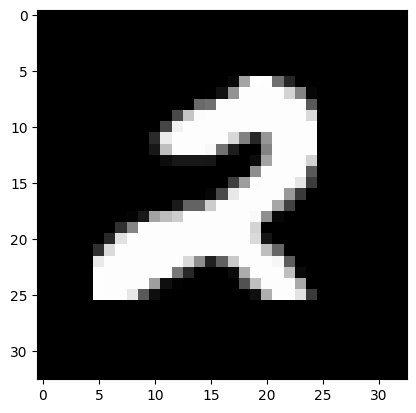

In [ ]:
plt.imshow(val_image[0], cmap='gray')

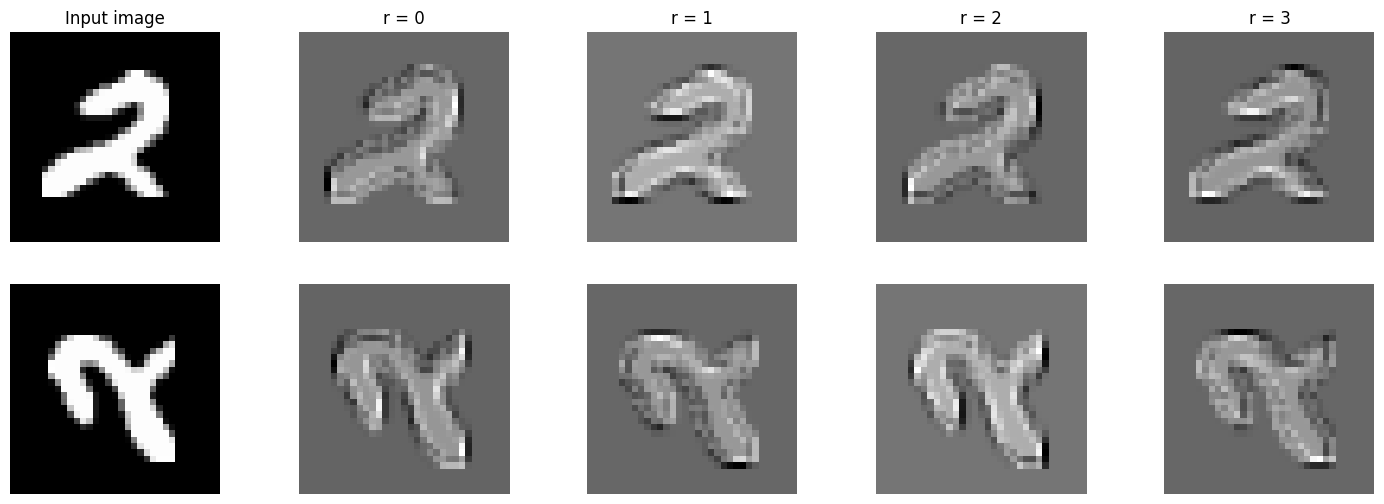

In [ ]:
plt.figure(figsize=(18, 6))

i = 0
plt.subplot(2, 5, i+1)
plt.axis("off")
plt.imshow(val_image[0], cmap='gray')
plt.title('Input image')

plt.subplot(2, 5, i+6)
plt.axis("off")
plt.imshow(rot_image[0], cmap='gray')

for i in range(1, 5):
    plt.subplot(2, 5, i+1)
    plt.axis("off")
    plt.imshow(output[0, 0, i - 1].detach().cpu().numpy(), cmap='gray')
    plt.title('r = {}'.format(i - 1))

    plt.subplot(2, 5, i+6)
    plt.axis("off")
    plt.imshow(rot_output[0, 0, i - 1].detach().cpu().numpy(), cmap='gray')
plt.show();

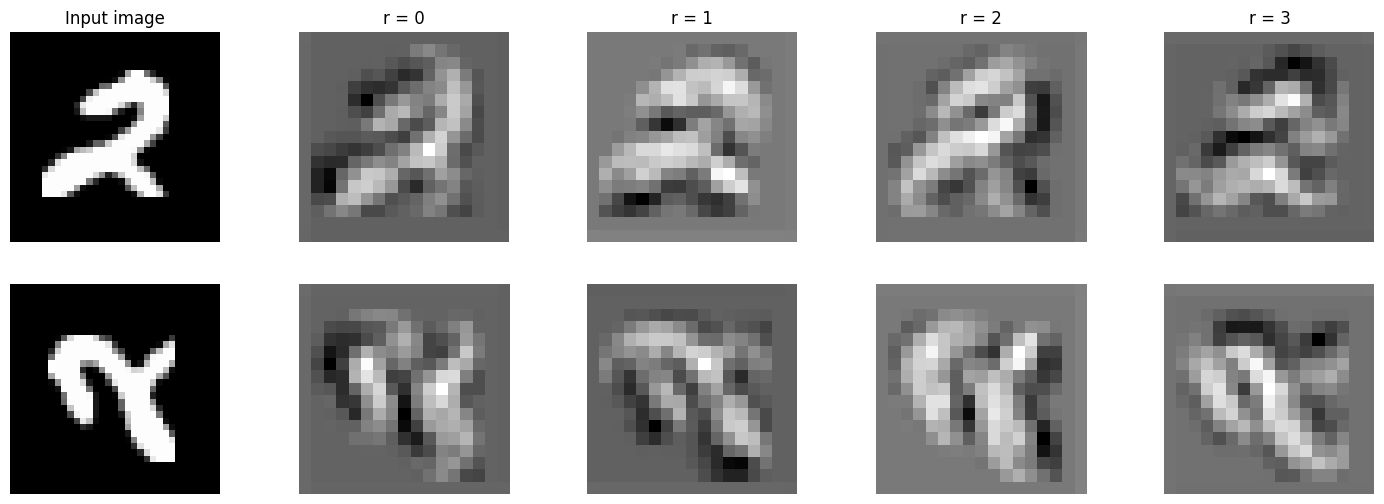

In [ ]:
output = model.layers[0:5](val_image.to(device))
rot_output = model.layers[0:5](rot_image.to(device))

plt.figure(figsize=(18, 6))
i = 0
plt.subplot(2, 5, i+1)
plt.axis("off")
plt.imshow(val_image[0], cmap='gray')
plt.title('Input image')

plt.subplot(2, 5, i+6)
plt.axis("off")
plt.imshow(rot_image[0], cmap='gray')

for i in range(1, 5):
    plt.subplot(2, 5, i+1)
    plt.axis("off")
    plt.imshow(output[0, 0, i - 1].detach().cpu().numpy(), cmap='gray')
    plt.title('r = {}'.format(i - 1))

    plt.subplot(2, 5, i+6)
    plt.axis("off")
    plt.imshow(rot_output[0, 0, i - 1].detach().cpu().numpy(), cmap='gray')
plt.show();